In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Introduction

This notebook introduces three resources for working with Japanese Kanji:

1. Heisig
2. KRAD
3. CHISE

Through examples, we show how you can apply each resource to break Kanji down into subcomponents.

If you're new to Kanji, you may want to read [this intro](https://kanjialive.com/214-traditional-kanji-radicals/).

# James Heisig: Remembering the Kanji

It is very difficult to work with Kanji without being able to conveniently name them.
For example, conveying the above example verbally in English can be frustrating, because in general, a single Kanji rarely has one, unambiguous meaning, and cannot be expressed by a single English word.
So, how can we refer to these things without becoming fluent in Japanese?

We cheat.  

We assign our own English _keywords_ to the Kanji.
Sometimes they will actually be related to the Kanji somehow, but that won't always be the case.
To reinforce the keywords, we make up our _personal_ story.
The story is your own, so it can be as silly as you like.
What matter is that _you made it, so you can remember it_.

## 鉄 iron

## 金 metal

## 失 to lose

So, one story could be something like:

> Iron is an essential metal for the human body, so it is important not to lose too much of it.

The above is known as the [Heisig Method](https://en.wikipedia.org/wiki/Remembering_the_Kanji_and_Remembering_the_Hanzi).

We can now:

1. Refer to Kanji using an unambiguous English keyword
2. Actually remember the Kanji by connecting it to the keyword via a story

We'll focus on the first point for now.
Let's get the Heisig keywords.
[@ziggr](https://twitter.com/ziggr) has conveniently put them into computer-readable form.

In [2]:
# ! wget http://ziggr.com/heisig/heisig-data.txt.gz

In [3]:
# The Heisig method assigns keywords to Kanji, and groups Kanji into lessons of increasing difficulty.
import csv
import gzip
import io
import pprint

def tweak(kanji):
    kanji.pop('keyword3rd-ed')
    kanji.pop('keyword4th-ed')
    kanji['keyword'] = kanji.pop('keyword5th-ed')
    for key, value in kanji.items():
        if value.isdigit():
            kanji[key] = int(value)
    return dict(kanji)

with gzip.GzipFile('heisig-data.txt.gz') as fin:
    fin.readline()
    reader = csv.DictReader(io.StringIO(fin.read().decode('utf-8')), delimiter=':')
    heisig = [tweak(x) for x in reader]
    
heisig_dict = {k['kanji']: k for k in heisig}
pprint.pprint(heisig_dict['鉄'])

{'#heisignumber': 846,
 'indexordinal': 1626,
 'kanji': '鉄',
 'keyword': 'iron',
 'lessonnumber': 25,
 'strokecount': 13}


In [4]:
def h1(*args):
    import IPython.core.display
    html = '<h1>' + ' '.join(args) + '</h1>'
    IPython.core.display.display(IPython.core.display.HTML(html))
    
# h1('hello world')

In [5]:
h1('鉄', heisig_dict['鉄']['keyword'])
h1('金', heisig_dict['金']['keyword'])
h1('失', heisig_dict['失']['keyword'])

In [6]:
# One catch: Heisig only covers a subset of the Kanji.
# These are the most commonly used Kanji, so it's a _good_ subset.
len(heisig)

2042

In [7]:
def from_stroke_count(stroke_count):
    """Return the list of Kanji that have the specified stroke count."""
    for k in heisig:
        if k['strokecount'] == stroke_count:
            yield k['kanji']
h1(*list(from_stroke_count(13))[:10])

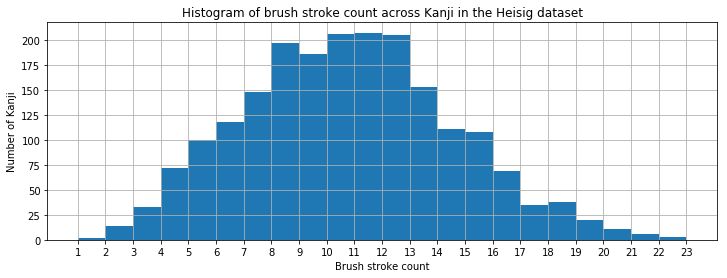

In [8]:
def plot_hist(counts):
    bins = list(range(1, max(counts) + 1))
    plt.figure(figsize=(12, 4))
    plt.hist(counts, bins=bins)
    plt.xticks(bins)
    plt.grid();
    
plot_hist([k['strokecount'] for k in heisig])
plt.title('Histogram of brush stroke count across Kanji in the Heisig dataset')
plt.ylabel('Number of Kanji')
plt.xlabel('Brush stroke count');

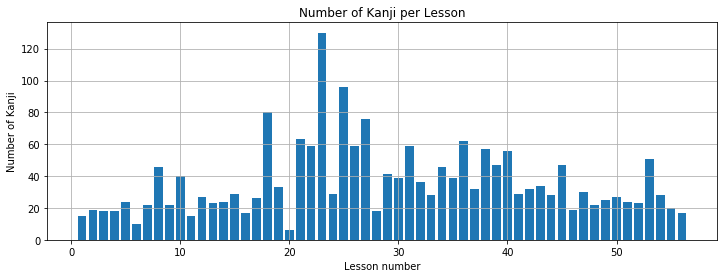

In [9]:
import collections

kanji_per_lesson = collections.defaultdict(int)
for kanji in heisig:
    kanji_per_lesson[int(kanji['lessonnumber'])] += 1
x = sorted(kanji_per_lesson.keys())
y = [kanji_per_lesson[xx] for xx in x]
plt.figure(figsize=(12, 4))
plt.bar(x, y)
plt.grid()
plt.xlabel('Lesson number')
plt.ylabel('Number of Kanji')
plt.title('Number of Kanji per Lesson');

In [10]:
heisig_lesson = {
    lesson: ''.join([k['kanji'] for k in heisig if int(k['lessonnumber']) == lesson])
    for lesson in kanji_per_lesson
}
h1(heisig_lesson[23])

In [11]:
# Our memory is not perfect, so it's convenient to go between keywords and Kanji quickly
to_keyword = {h['kanji']: h['keyword'] for h in heisig_dict.values()}
h1(to_keyword['旭'])

In [12]:
from_keyword = {h['keyword']: h['kanji'] for h in heisig_dict.values()}
h1(from_keyword['rising sun'])

In [13]:
# Short names for convenience
fkw = from_keyword
tkw = to_keyword

# KRAD

The [KRAD project](http://www.edrdg.org/krad/kradinf.html) is of the many useful projects of [Electronic Dictionary Research & Development Group](http://www.edrdg.org/edrdg/index.html).
It consists of two mappings: Kanji to radical (krad) and radical to Kanji (radk).
Since we're breaking down Kanji, we're more interested in the former.
Let's download the file and have a peek at it.

(Remember: a _radical_ is just a fancy word for "part of a Kanji")

In [14]:
# Simplest way to acquire the file is with wget, if you're in a GNU environment.
#
# ! wget ftp://ftp.monash.edu/pub/nihongo/kradfile.gz

In [15]:
import gzip
with gzip.GzipFile('kradfile.gz') as fin:
    krad = fin.read().decode('euc-jp')
    
# The krad file describes the radicals present in each Kanji
for line in krad.split('\n')[100:120]:
    h1(line)

In [16]:
# It's really easy to parse...
def parse_krad():
    for line in krad.split('\n'):
        if line and line[0] == "#":
            continue
        elif ' : ' in line:
            kanji, radicals = line.split(' : ')
            radicals = radicals.split(' ')
            yield kanji, radicals
        
krad_dict = dict(parse_krad())

# So now, we can get the radicals present in any Kanji.  Cool, huh?
h1(*krad_dict['鉄'])

In [17]:
# What are the most common radicals?
import collections
radicals = collections.Counter()
for val in krad_dict.values():
    radicals.update(val)

radicals.most_common(10)

[('口', 1340),
 ('一', 991),
 ('｜', 646),
 ('ノ', 626),
 ('木', 601),
 ('日', 593),
 ('ハ', 542),
 ('二', 476),
 ('土', 463),
 ('田', 461)]

In [18]:
# How many unique Kanji?
len(krad_dict)

6355

In [19]:
# How many unique radicals are there?
len(radicals)

254

In [20]:
def demo(function):
    def inner(*args, **kwargs):
        retval = function(*args, **kwargs)
        h1('%s %r %r --> %r' % (function.__name__, args, kwargs, retval))
        return retval
    return inner


def find_common_radicals(k1, k2):
    """Return the common radicals between the two Kanji."""
    rad1 = set(krad_dict[k1])
    rad2 = set(krad_dict[k2])
    return rad1.intersection(rad2)


def parent_child(k1, k2):
    """Return 1 if k1 is a parent of k2, or the other way around.
    
    A parent Kanji contains all the radicals of a child Kanji, plus more."""
    rad1 = set(krad_dict.get(k1, [k1]))
    rad2 = set(krad_dict.get(k2, [k2]))
    common = rad1.intersection(rad2)
    # print(rad1, rad2, common)
    if common == {k1} or common == {k2}:
        return 1
    return 1 if (common == rad1 or common == rad2) else 0

demo(parent_child)('月', '朝')
demo(parent_child)('扎', fkw['challenge'])
demo(parent_child)(fkw['busy'], fkw['hate'])

1

In [21]:
# Can we measure similarity between two Kanji?
h1(*find_common_radicals('涼', '景'))

In [22]:
def find_similar_kanji(kanji, threshold=1):
    sim = sorted(
        ((len(find_common_radicals(kanji, k)), k) for k in krad_dict),
        reverse=True
    )
    return [k for (s, k) in sim if s > threshold and k != kanji]

h1('難')
h1(*find_similar_kanji('難', threshold=3))

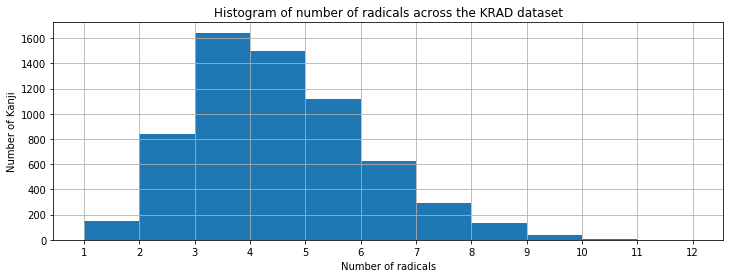

In [23]:
plot_hist([len(radicals) for (kanji, radicals) in krad_dict.items()])
plt.title('Histogram of number of radicals across the KRAD dataset')
plt.ylabel('Number of Kanji')
plt.xlabel('Number of radicals');

In [24]:
# Are there Kanji that have the same radicals, but in different arrangements?
# Looks like there's quite a few...
by_radicals = collections.defaultdict(list)
for kanji, radicals in krad_dict.items():
    key = tuple(sorted(set(radicals)))
    by_radicals[key].append(kanji)

for rad in sorted([" ".join(x) for x in by_radicals.values()], 
                  key=lambda item: len(item), reverse=True)[:20]:
    h1(*rad)

In [25]:
# Problems:
#   1. The order of the radicals appears to be quite random
#   2. No positional information

# KANJIDIC

A dictionary that contains many useful properties for each Kanji.

In [26]:
# KANJIDIC

# ! wget http://ftp.monash.edu.au/pub/nihongo/kanjidic.gz

In [27]:
KANJIDIC_FIELDS = ['MN', 'MP'] + list("UNBCSGHFPKLIQ")
"""
[U] the Unicode/ISO 10646 code of the kanji in hexadecimal;
[N] the index in Nelson (Modern Reader's Japanese-English Character Dictionary)
[B] the classification radical number of the kanji (as in Nelson);
[C] the "classical" radical number (where this differs from the one used in Nelson);
[S] the total stroke-count of the kanji;
[G] the "grade" of the kanji, In this case, G2 means it is a Jouyou (general use) kanji taught in the second year of elementary schooling in Japan;
[H] the index in Halpern (New Japanese-English Character Dictionary);
[F] the rank-order frequency of occurrence of the kanji in Japanese;
[P] the "SKIP" coding of the kanji, as used in Halpern;
[K] the index in the Gakken Kanji Dictionary (A New Dictionary of Kanji Usage);
[L] the index in Heisig (Remembering The Kanji);
[I] the index in the Spahn & Hadamitsky dictionary.
[Q] the Four-Corner code;
[MN,MP] the index and page number in the 13-volume Morohashi "DaiKanWaJiten";
[E] the index in Henshall (A Guide To Remembering Japanese Characters);
[Y] the PinYin (Chinese) pronunciation(s) of the kanji;
"""
def parse_kanjidic_parts(parts):
    readings = []
    meanings = []
    for part in parts:
        if part[0] == '{' and part[-1] == '}':
            meanings.append(part[1:-1])
            break
        for field in KANJIDIC_FIELDS:
            if part.startswith(field):
                yield field, part[len(field):]
                break
        else:
            readings.append(part)
    yield 'meanings', meanings
    # Contains stuff other than the readings now
    # yield 'readings', readings

def parse_kanjidic():
    with gzip.GzipFile('kanjidic.gz') as fin:
        next(fin)
        for line in fin:
            # http://www.edrdg.org/kanjidic/kanjidic.html
            parts = line.decode('euc-jp').split(' ')
            kanji = parts.pop(0)
            jis_code = parts.pop(1)
            info = dict(parse_kanjidic_parts(parts))
            info.update(kanji=kanji, jis_code=jis_code)
            yield info
            
kanjidic = {x['kanji']: x for x in parse_kanjidic()}
kanjidic[fkw['rain']]

{'B': '173',
 'G': '1',
 'S': '8',
 'F': '950',
 'N': '5042',
 'H': '3561',
 'L': '422',
 'K': '655',
 'MN': '42210',
 'MP': '12.0001',
 'I': '8d0.1',
 'P': '4-8-1',
 'Q': '1022.7',
 'meanings': ['rain'],
 'kanji': '雨',
 'jis_code': 'U96e8'}

In [28]:
len(collections.Counter([k['B'] for k in kanjidic.values()]))

216

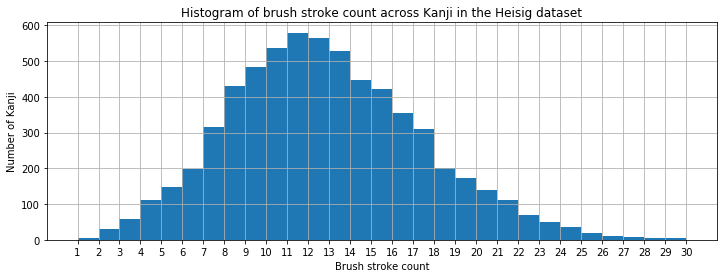

In [35]:
def kanjidic_strokes():
    for k in kanjidic.values():
        try:
            yield int(k['S'])
        except ValueError:
            pass
        
plot_hist(list(kanjidic_strokes()))
plt.title('Histogram of brush stroke count across Kanji in the Heisig dataset')
plt.ylabel('Number of Kanji')
plt.xlabel('Brush stroke count');

In [56]:
def from_strokecount(*counts):
    for k in kanjidic.values():
        try:
            sc = int(k['S'])
        except ValueError:
            pass
        else:
            if sc in counts:
                yield k
                
import random
h1("　".join(random.sample([k['kanji'] for k in from_strokecount(*list(range(27, 31)))], 7)))

# CHISE (Character Information Service Environment)

The [CHISE](http://www.chise.org/ids/index.html) project is similar to the krad file we looked at above.
However, instead of decomposing a Kanji into a mere set of radicals, they decompose each Kanji into ideographs (essentially, simpler Kanji) and keep track of the _position_ of each ideograph within the Kanji, as well as the number of times that it appears.  This can be more helpful than krad.

In [ ]:
# ! wget "http://git.chise.org/gitweb/?p=chise/ids.git;a=blob_plain;f=IDS-UCS-Basic.txt" -O IDS-UCS-Basic.txt

In [ ]:
chise = open('IDS-UCS-Basic.txt', encoding='utf-8').read().rstrip()
for line in chise.split('\n')[20:30]:
    h1(line)

In [ ]:
def parse_chise_ideographs(text):
    #
    # Each ideograph is either:
    # 
    #     1) A single character, where a character for the ideograph actually exists
    #     2) An escape code in the form of "&CDP-FFFF;", where FFFF is hex for the code.
    #
    while text:
        if text.startswith('&'):
            end = text.index(';')
            yield text[:end + 1]
            text = text[end + 1:]
        else:
            yield text[0]
            text = text[1:]
    
def parse_chise():
    for line in chise.split('\n')[1:]:
        code_point, kanji, ideographs = line.rstrip().split('\t', 2)
        yield kanji, list(parse_chise_ideographs(ideographs))
        
chise_dict = dict(parse_chise())
h1('鉄')
h1(*chise_dict['鉄'])

In [ ]:
len(chise_dict)

In [ ]:
''.join(chise_dict.keys())

In [ ]:
import random
chise_heisig = {k: v for (k, v) in chise_dict.items() if k in heisig_dict}
for key, value in random.sample(chise_heisig.items(), 10):
    h1(key, "".join(value))

In [ ]:
for k in "庁 ⿸广丁":
    try:
        kd = heisig_dict[k]
        meaning = kd['keyword']
    except (KeyError, IndexError):
        meaning = None
        
    print(k, meaning)

In [ ]:
# Let's look at the available Kanji layouts.
# Recall that the first element in the ideograph list is the layout.
import collections
most_common = collections.Counter(ideo[0] for ideo in chise_dict.values()).most_common(12)
most_common

In [ ]:
h1(*[layout for (layout, count) in most_common])

In [ ]:
most_common_names = [            # For the purists, the Japanese equivalent is below:
    'left-right',                # hen/dzukuri
    'above-below',               # kanmuri/ashi
    'surround-from-upper-left',  # tare
    'surround-from-lower-left',  # nyou
    'surround-from-above',       # kamae (enclosing)
    'above-middle-below',        # ?
    'full-surround',             # kamae
    'surround-from-upper-right', # kamae
    'left-middle-right',         # ?
    'surround-from-left',        # kamae
    'overlaid',                  # ?
    'surround-from-below',       # kamae
]
#
# By far the most common layout is left-to-right, followed by top-and-bottom.
# The remaining layouts are far less common, which is possibly why the Japanese
# gave up trying to think up new names for them, and just called them all "kamae". 
#
# Let's plot the above, just because we can
#
most_common_count = [count for (layout, count) in most_common]
y_pos = list(reversed(range(len(most_common_count))))

plt.figure(figsize=(12, 4))
plt.barh(y_pos, most_common_count)
plt.yticks(y_pos, most_common_names)
plt.title('frequency of layouts in the CHISE dataset')
plt.grid();

In [ ]:
layouts = [layout for (layout, count) in most_common]

def filter_layouts(parts):
    return [p for p in parts if p not in layouts]

plot_hist([len(filter_layouts(parts)) for (kanji, parts) in chise_dict.items()])
plt.title('Histogram of number of components across the CHISE dataset')
plt.ylabel('Number of Kanji')
plt.xlabel('Number of parts');

In [ ]:
# Sometimes, you have to perform multiple look-ups to break a Kanji up entirely
h1('恕')
h1(*chise_dict['恕'])
h1(*chise_dict['如'])

In [ ]:
# Let's define a function to do that
def chise_split(kanji):
    try:
        ideographs = chise_dict[kanji]
    except KeyError:
        return [kanji]
    if len(ideographs) == 1:
        return ideographs
    result = []
    for i in ideographs:
        result.extend(chise_split(i))
    return result

h1(*chise_split('恕'))

In [ ]:
h1(*chise_split('鉄'))

In [ ]:
h1(*krad_dict['鉄'])

In [ ]:
# TODO: the above represents a traversal of a binary tree

In [ ]:
# ... but we digress.  Let's get back to the actual data:
h1(*chise_dict['鉄'])

The ideographs should be interpreted in [Polish notation](https://en.wikipedia.org/wiki/Polish_notation).
In the example above, the first character outlines the layout of the Kanji: left-to-right.
The following characters correspond to the left and right parts of the Kanji, respectively.
So the above example effectively says that 

# 鉄

can be constructed by squishing the following two characters together:

## 金　失

In [ ]:
# You can also flip the mapping to go the other way around
import collections
inv_chise_dict = collections.defaultdict(list)
for kanji, ideographs in chise_dict.items():
    for i in ideographs:
        inv_chise_dict[i].append(kanji)

# Find the Kanji that contains both 金 and 失
h1(*set(inv_chise_dict['金']).intersection(set(inv_chise_dict['失'])))

# This is particularly helpful when you know _part_ of a Kanji, but don't know the rest of it

In [ ]:
# The above is so useful!  Let's generalize into a function
def chise_narrow(*parts):
    parts = list(parts)
    first_part = parts.pop()
    candidates = set(inv_chise_dict[first_part])
    while parts:
        candidates = candidates.intersection(set(inv_chise_dict[parts.pop()]))
    return candidates

h1(*chise_narrow('心', '口'))

In [ ]:
'止' in chise_dict['正']

In [ ]:
# Sometimes, we have to do _multiple_ CHISE breakdowns to determine membership
'止' in chise_dict['政']

In [ ]:
def chise_contains(parent, candidate):
    """Return True if the parent Kanji contains the candidate Kanji."""
    try:
        children = chise_dict[parent]
    except KeyError:
        # Don't know how to decompose this Kanji
        return False
    if candidate in children:
        return True
    elif children == [parent]:
        # We cannot decompose this Kanji any further using CHISE.
        return False
    for child in chise_dict[parent]:
        if chise_contains(child, candidate):
            return True
    return False


demo(chise_contains)('正', '止')
demo(chise_contains)('政', '止')
demo(chise_contains)('涼', '水')
demo(chise_contains)('涼', '氵')
demo(chise_contains)('渉', '止')

In [ ]:
chise_dict[fkw['just so']]

In [ ]:
chise_dict[fkw['bridegroom']]

In [ ]:
chise_dict['胥']

In [ ]:
# Some questions:
#
# - How many of these escapes are there? It looks like &CDP-8958; should really be equivalent to 月
# - 𤴓 is _really_ similar to 疋. How many other such pairs are there?

In [ ]:
krad_dict['疋']

In [ ]:
# krad_dict['𤴓']

# Unleash the Graphs

In [ ]:
def includes(part, superpart):
    # print(child, chise_parent)
    try:
        return part in chise_dict[superpart]
    except KeyError:
        return False

demo(includes)('止', '正')
demo(includes)('歩', '頻')
demo(includes)('宀', fkw['dormitory'])

In [ ]:
import matplotlib.font_manager

#
# Getting Japanese fonts to work with Networkx can bit a little tricky.
#
# https://qiita.com/grachro/items/4c9b03366cae2df3a301
# https://linuxfan.info/ubuntu-18-04-change-ja-font
# https://showa-yojyo.github.io/notebook/python-networkx/drawing.html 
#
fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
jp_fonts = [f for f in fonts if 'takao' in f.lower()]
print(jp_fonts)
jp_prop = matplotlib.font_manager.FontProperties(fname=jp_fonts[0])
jp_prop.set_size(40)

In [ ]:
def radical_similarity(kanji1, kanji2):
    return len(find_similar_radicals(kanji1, kanji2))

def normed_radical_similarity(kanji1, kanji2):
    num_similar = len(find_similar_radicals(kanji1, kanji2))
    num1 = len(krad_dict[kanji1])
    num2 = len(krad_dict[kanji2])
    return num_similar / (num1 + num2)

In [ ]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, write_dot
import IPython.display

LAYOUTS = '⿰ ⿱ ⿸ ⿺ ⿵ ⿳ ⿴ ⿹ ⿲ ⿷ ⿻ ⿶'


def plot_chise_helper(graph, kanji, depth, order, max_depth, parent_node_name=None):
    try:
        parts = chise_dict[kanji]
        if parts == [kanji]:
            parts = []
    except KeyError:
        parts = []
        
    print(kanji, parts)
    
    #
    # We name the nodes based on the order and depth so that graphviz
    # orders them correctly.
    #
    node_name = '%d_%d' % (depth, order)
    graph.add_node(node_name, label=kanji)
    if parent_node_name is not None:
        graph.add_edge(parent_node_name, node_name)
        
    if depth >= max_depth:
        return
    
    if (not parts) or (parts[0] not in LAYOUTS):
        return
    
    layout_name = '%s_%s' % (parts[0], depth)
    
    graph.add_node(layout_name, label=parts[0])
    graph.add_edge(node_name, layout_name)
    
    children = parts[1:]
    for order, part in enumerate(children):
        plot_chise_helper(graph, part, depth + 1, order, max_depth, parent_node_name=layout_name)


def plot_chise(kanji, figsize=(12, 6), max_depth=3):
    """Plot a tree with the CHISE breakdown for a single Kanji."""
    graph = nx.DiGraph()
    
    plot_chise_helper(graph, kanji, 0, 1, max_depth)
    
    fix, ax = plt.subplots(figsize=figsize)
    positions = graphviz_layout(graph, 'dot')
    
    nx.draw(graph, pos=positions, with_labels=False, font_weight='bold',
            node_color='#aaaaaa', node_size=1000, edge_color='#999999')
    labels = {key: value.get('label', '') for (key, value) in graph.nodes().items()}
    label_positions = nx.draw_networkx_labels(graph, positions, labels=labels)
    
    for text in label_positions.values():
        text.set_fontproperties(jp_prop)
    
    plt.show()
    return graph

#
# Why can't we print the layout characters?!
#
# https://askubuntu.com/questions/425030/how-can-i-determine-which-installed-fonts-can-display-a-certain-glyph
# https://askubuntu.com/questions/463798/how-to-check-if-a-ttf-file-contains-a-certain-character
#
# It works if we output via graphviz (dot -Tpng < graph.dot > image.png)...
#
graph = plot_chise("露", max_depth=3)
write_dot(graph, 'plot_chise.dot')
!dot -Tpng < plot_chise.dot > plot_chise.png
IPython.display.Image('plot_chise.png')

In [ ]:
graph = plot_chise(fkw['prison'])
write_dot(graph, 'plot_chise.dot')
!dot -Tpng < plot_chise.dot > plot_chise.png
IPython.display.Image('plot_chise.png')

In [ ]:
graph = plot_chise('疫');
write_dot(graph, 'plot_chise.dot')
!dot -Tpng < plot_chise.dot > plot_chise.png
IPython.display.Image('plot_chise.png')

In [ ]:
tkw['疫']

In [ ]:
def yield_words(kanji):
    for k, v in chise_dict.items():
        if kanji in v and k in kanjidic:
            for m in kanjidic[k]['meanings']:
                yield m
words = list(yield_words('氵'))

In [ ]:
# !pip install wordcloud
words

In [ ]:
import wordcloud


def show_cloud(kanji):
    words = list(yield_words(kanji))
    
    # Generate a word cloud image
    wc = wordcloud.WordCloud().generate(" ".join(words))

    # Display the generated image:
    # the matplotlib way:
    import matplotlib.pyplot as plt
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
show_cloud(fkw['woman'])

In [ ]:
import collections
import itertools

import matplotlib.pyplot as plt

def construct_graph(kanji_list, edge_function, threshold=0, is_digraph=False):
    """Construct a graph that covers the specified Kanji."""
    if is_digraph:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    for k in kanji_list:
        try:
            keyword = heisig_dict[k]['keyword']
        except:
            keyword = ''
        G.add_node(k, keyword=keyword)

    for k1, k2 in itertools.permutations(kanji_list, 2):
        weight = edge_function(k1, k2)
        if weight > threshold:
            # print(k1, k2, weight, threshold)
            G.add_edge(k1, k2, weight=weight)
    return G

def plot_graph(G, figsize=(12, 6), show_labels=True, model='dot'):
    fig, ax = plt.subplots(figsize=figsize)
    
    if model == 'spring':
        positions = nx.spring_layout(G)
    else:
        positions = graphviz_layout(G, model)
    
    nx.draw(G, pos=positions, with_labels=False, font_weight='bold',
            node_color='#aaaaaa', node_size=1000, edge_color='#999999')
    label_positions = nx.draw_networkx_labels(G, positions)
    for text in label_positions.values():
        text.set_fontproperties(jp_prop)
        
    if show_labels:
        #
        # Some magic to dynamically determine the proper offset for the label
        # https://stackoverflow.com/questions/43894987/networkx-node-labels-relative-position
        #
        renderer = fig.canvas.get_renderer()
        trans = plt.gca().transData.inverted()
        text = list(label_positions.values())[0]
        bounding_box = text.get_window_extent(renderer=renderer)
        bounding_box_data = bounding_box.transformed(trans)
        text_height = bounding_box_data.y1 - bounding_box_data.y0
        dy = 14 * text_height / 20
        
        keywords = {key: value['keyword'] for key, value in G.nodes().items()}
        keyword_positions = {k: (x, y - dy) for (k, (x, y)) in positions.items()}
        label_positions = nx.draw_networkx_labels(
            G, keyword_positions, labels=keywords, font_size=12, font_color='#ff0000'
        )

    plt.show()

def plot_heisig_lesson(lesson_number):
    kanji = heisig_lesson[lesson_number]
    radicals = collections.Counter()
    for k in kanji:
        radicals.update(krad_dict[k])
    kanji_plus_radicals = list(kanji) + [x for x, y in radicals.most_common(10)]
    
    G = construct_graph(kanji_plus_radicals, parent_child, is_digraph=False)
    plot_graph(G, model='neato')
    
    # print(sorted(nx.degree_centrality(G).items(), key=lambda x: x[1], reverse=True)[:10])
    
    return G
    
G = plot_heisig_lesson(17)

In [ ]:
krad_dict[fkw['challenge']]

In [ ]:
parent_child('扎', fkw['challenge'])

In [ ]:
chise_dict[fkw['walk']]

In [ ]:
chise_dict[fkw['repeatedly']]

In [ ]:
# Seems like a CHISE error
fkw['walk'], chise_dict[fkw['repeatedly']][1]

In [ ]:
def overlaps(kanji1, kanji2):
    try:
        k1 = chise_dict[kanji1]
        k2 = chise_dict[kanji2]
        if any([part in k2 for part in k1]):
            return True
        if any([part in k1 for part in k2]):
            return True    
    except KeyError:
        pass
    return False
    
demo(overlaps)(fkw['forehead'], fkw['petition'])

In [ ]:
def same_first_part(kanji1, kanji2):
    try:
        k1 = chise_dict[kanji1]
        k2 = chise_dict[kanji2]
    except KeyError:
        return False
    if k1[0] != k2[0]:
        return False
    return k1[1] == k2[1]

demo(same_first_part)(fkw['iron'], fkw['silver'])
demo(same_first_part)(fkw['iron'], fkw['gold'])

In [ ]:
heisig_kanji = set(heisig_dict)
heisig_parts = set()
for k in heisig_kanji:
    try:
        parts = chise_dict[k]
    except KeyError:
        continue
    # Exclude escape codes
    heisig_parts |= set([p for p in parts if p not in layouts and len(p) == 1])
heisig_kanji |= heisig_parts
assert '宀' in heisig_kanji

G = construct_graph(heisig_kanji, includes)
CC = list(nx.connected_components(G))

In [ ]:
len(CC)

In [ ]:
largest_cc = sorted(CC, key=len, reverse=True)[0]
''.join(largest_cc)

In [ ]:
len(largest_cc)

In [ ]:
nx.shortest_path(G, '硫', '判')

In [ ]:
nx.shortest_path(G, '硫', '畔')

In [ ]:
G_heisig = construct_graph(heisig_kanji, includes, is_digraph=True)
nx.write_yaml(G_heisig, 'graph.yml')

In [ ]:
def search(graph, node, seen, depth=1000, min_strokes=0, max_strokes=1000):
    seen.add(node)
    
    if depth == 0:
        return
    
    neighbors = [src for (src, dst) in graph.in_edges([node])]
    neighbors += [dst for (src, dst) in graph.out_edges([node])]
    
    for n in neighbors:
        try:
            dest_strokes = int(kanjidic[n]['S'])
        except KeyError:
            dest_strokes = 0
        if n not in seen and min_strokes <= dest_strokes < max_strokes:
            search(graph, n, seen, depth - 1)

In [ ]:
def focus(kanji, depth=3, model='dot', min_strokes=0, max_strokes=1000):
    seen = set([kanji])
    search(G_heisig, kanji, seen, depth=depth, min_strokes=min_strokes, max_strokes=max_strokes)
    sub = G_heisig.subgraph(seen)
    plot_graph(sub, model=model)

focus('洋', depth=1)

In [ ]:
focus(fkw['dormitory'], depth=2, model='neato')

In [ ]:
focus(fkw['month'], depth=2, model='neato')

In [ ]:
focus(fkw['fire'], depth=2, model='neato')

In [ ]:
focus(fkw['water'], model='dot', depth=2)

In [ ]:
focus(fkw['tree'], depth=1, model='neato')

In [ ]:
focus(fkw['gold'], depth=1, model='neato')

In [ ]:
focus(fkw['soil'], depth=1, model='neato', max_strokes=10)

In [ ]:
focus(fkw['soil'], depth=1, model='neato', min_strokes=10)

In [ ]:
focus(fkw['day'], depth=1, model='neato')

In [ ]:
focus(fkw['signature'], depth=2)

In [ ]:
focus(fkw['woman'], model='neato', max_strokes=10, depth=2)

In [ ]:
includes(fkw['signature'], fkw['eye'])

In [ ]:
chise_dict[fkw['dormitory']]

In [ ]:
includes(fkw['dormitory'], fkw['large'])